In [2]:
using Revise

using QuanticsTCI
using TensorCrossInterpolation
import TensorCrossInterpolation: TensorCI
using ITensors
using PyPlot

Did not find xfac. QTT functions will not be available.PyError (PyImport_ImportModule

The Python package xfacpy could not be imported by pyimport. Usually this means
that you did not install xfacpy in the Python version being used by PyCall.

PyCall is currently configured to use the Python version at:

/Users/Ritter.Marc/.pyenv/versions/3.8.15/bin/python

and you should use whatever mechanism you usually use (apt-get, pip, conda,
etcetera) to install the Python package containing the xfacpy module.

One alternative is to re-configure PyCall to use a different Python
version on your system: set ENV["PYTHON"] to the path/name of the python
executable you want to use, run Pkg.build("PyCall"), and re-launch Julia.

Another alternative is to configure PyCall to use a Julia-specific Python
distribution via the Conda.jl package (which installs a private Anaconda
Python distribution), which has the advantage that packages can be installed
and kept up-to-date via Julia.  As explained in the P

In [3]:
struct quantics_grid
    n::Int
    npoints::Int
    grid::Array{Real}

    function quantics_grid(grid::Array{Real})
        n = Int ∘ floor ∘ log2 ∘ length(grid)
        if (2^n ≂̸ length(grid))
            throw(ArgumentError("Length of grid must be a power of 2."))
        end
        new(n, 2^n, grid)
    end

    function quantics_grid(n, minval, maxval)
        new(n, 2^n, range(minval, maxval, length=2^n))
    end

    quantics_grid(n, maxval=1) = quantics_grid(n, 0, maxval)
end

Base.broadcastable(g::quantics_grid) = Ref(g)

function index_to_quantics(g::quantics_grid, i::Int)
    QuanticsTCI.index_to_quantics(i, g.n)
end

function quantics_to_value(g::quantics_grid, q::Array{Int})
    g.grid[quantics_to_index(q)[1]]
end

quantics_to_value (generic function with 1 method)

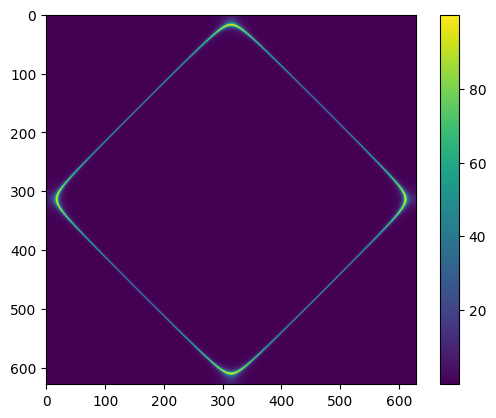

PyObject <matplotlib.colorbar.Colorbar object at 0x290ac6f10>

In [4]:
n = 18

D = 2.0
e_k(ks) = -D * sum(cos.(ks))

ω = -π/1e2
omegapoints = quantics_grid(8, -D, D)
kpoints = quantics_grid(n, -π, π)

plotstep = max(1, div(kpoints.npoints, 1024))

G(omega, delta, ks) = -1 / (omega + 1im * delta - e_k(ks))

kgrid = [(kx, ky) for kx in -pi:1e-2:pi, ky in -pi:1e-2:pi]
p = imshow(G.(ω, 1e-2, kgrid).|>imag)
colorbar(p)

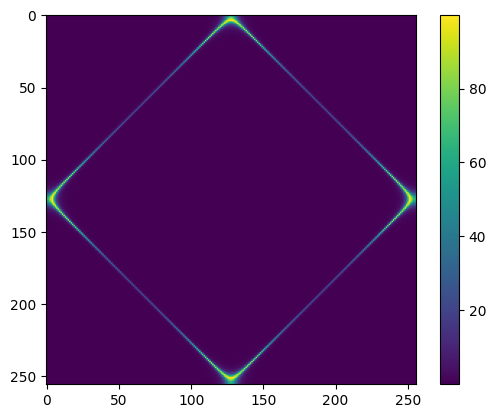

PyObject <matplotlib.colorbar.Colorbar object at 0x29154b340>

In [5]:
function G_quantics(δ, q, d)
    omega = omegapoints.grid[q[1]]
    kqs = split_dimensions(q[2:end], d)
    G(omega, δ, quantics_to_value.(kpoints, kqs))
end

kgrid = round.(Int, range(1, kpoints.npoints; length=256))

omegainit = div(length(omegapoints.grid), 2)
grid = [
    merge_dimensions(
        index_to_quantics(kpoints, kx),
        index_to_quantics(kpoints, ky))
        for kx in kgrid, ky in kgrid
]
p = imshow([imag(G_quantics(1e-2, [omegainit, p...], 2)) for p in grid])
colorbar(p)

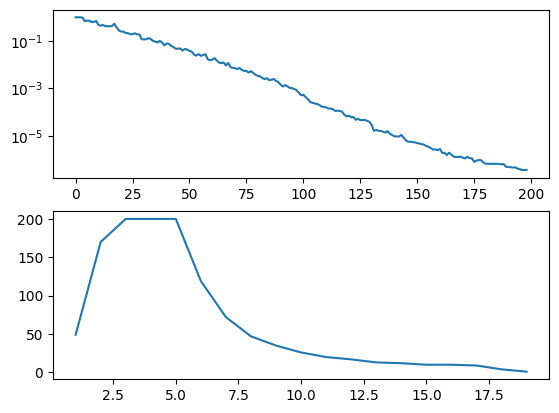

In [12]:
struct qttres
    qtt::Vector{Array{Float64, 3}}
    ranks::Vector{Int}
    errors::Vector{Float64}
end

function qttres(tci::TensorCI{Float64}, ranks::Vector{Int}, errors::Vector{Float64})
    return qttres(tensortrain(tci), ranks, errors)
end

deltas = 10.0 .^[-0]

firstpivot = [
    omegainit,
    merge_dimensions(
        index_to_quantics(kpoints, 2^(kpoints.n - 1)),
        index_to_quantics(kpoints, 0))...]

localdimensions = [length(omegapoints.grid), fill(2^2, n)...]

qtts = qttres[]

for delta in deltas
    f(q) = imag(G_quantics(delta, q, 2))
    firstpivot = TensorCrossInterpolation.optfirstpivot(f, localdimensions, firstpivot)
    tci, ranks, errors =
        crossinterpolate(
            f,
            localdimensions,
            firstpivot,
            maxiter=200, tolerance=1e-8)
    push!(
        qtts,
        qttres(tci, ranks, errors)
    )
end

fig, axs = subplots(nrows=2)
for res in qtts
    axs[1].semilogy(res.errors)
    axs[2].plot(1:length(res.qtt), [size(M)[end] for M in res.qtt])
end

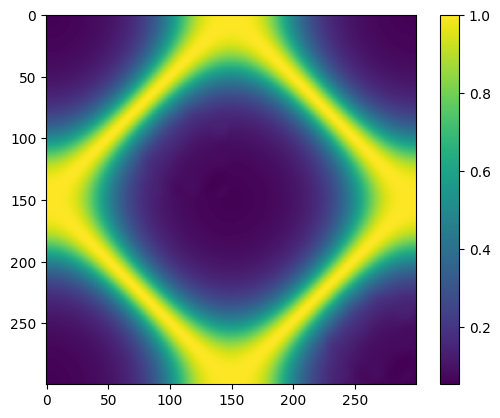

PyObject <matplotlib.colorbar.Colorbar object at 0x2a65ee040>

In [11]:
val = qtts[end].qtt
mps = qtt_to_mps(val, [Index(length(omegapoints.grid), "site"), [Index(4, "site") for i in val]...])

function eval(kx, ky)
    q = [
        omegainit,     
        merge_dimensions(
            index_to_quantics(kpoints, kx),
            index_to_quantics(kpoints, ky))...]
    evaluate_mps(mps, siteinds(mps), q)
end

kgrid = round.(Int, range(1, kpoints.npoints, length=300))
p = imshow([eval(kx, ky) for kx in kgrid, ky in kgrid])
colorbar(p)

In [ ]:
function partial_sum_quantics_mps(G2_mps)
    n = Int(length(mps) // 2)
    G2_mps_summed = MPS(n)
    for i in 1:n
        s = siteind(G2_mps, 2*i)
        G2_mps_summed[i] = G2_mps[2 * i - 1] * G2_mps[2 * i] * ITensor(1, s)
        #G2_mps_summed[i] = ITensor(1, s) * G2_mps[2 * i - 1] * G2_mps[2 * i]
    end
    return G2_mps_summed
end

partial_sum_quantics_mps (generic function with 1 method)